# Fine-tuning GPT-2 for text classification
Stefan/Yuzhao Heng
Since Wed. Feb. 9th, 2022


Reproduce the results in paper [Zero-shot Text Classification With Generative Language Models](https://arxiv.org/abs/1912.10165),
since the authors didn't release the code.

Serve as infrastructure and baseline for project on efficient and accurate encoder for text classification with many labels.


## Notebook Setup



In [1]:
%load_ext autoreload
%autoreload 2



## Colab Setup



In [2]:
import os
import sys


if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    ! pip3 install sty icecream transformers datasets

    # base_path = '/content/drive/My Drive//Research/'
    # os.chdir(os.path.join(base_path, 'Unified Encoder/Unified-Encoder'))

    sys.path.append(os.path.join('drive', 'My Drive', 'Research', 'Unified Encoder', 'Unified-Encoder'))


from zeroshot_biencoder.util import *
print(PATH_BASE, DIR_PROJ, PKG_NM)  # Sanity check, should be the path appended if Colab



/Users/stefanh/Documents/UMich/Research/Clarity Lab/Unified Encoder Unified-Encoder zeroshot_biencoder


## Setup



In [3]:
import random

import numpy as np
import torch
import transformers
from icecream import ic

from zeroshot_biencoder.baseline import gpt2


rcParams['figure.dpi'] = 200
rcParams['font.size'] = 6



## Seed setup



In [4]:
if torch.cuda.is_available():
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # Required for some CuBLAS operations
    ! echo $CUBLAS_WORKSPACE_CONFIG


seed = config('random-seed')
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)
transformers.set_seed(seed)



## Prep Model & Dataset for training


In [5]:
# nm, n = 'debug', 8
nm, n = 'debug-large', 128
model, tokenizer, data_collator, train_args, dset_tr, dset_vl, trainer = gpt2.get_all_setup(
    nm, n_sample=n, random_seed=seed
)



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'ZsGPT2Tokenizer'.
Using custom data configuration default
Reusing dataset ag_news (/Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-22d5a63da5486d60.arrow
Loading cached processed dataset at /Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-4a12e02caeaecc36.arrow
Loading cached shuffled indices for dataset at /Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-bd4c21e46951b363.arrow
Loading cached shuffled indices for dataset at /Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-75008ef255283e83.arrow


## Train


2022-02-16 14:09:58| [GPT-2 Training]::on_train_begin::gpt2.py:482, INFO - Training started with {#data: 8, model size: 4, learning rate: 0.0001, batch size: 4, #epochs: 4}
2022-02-16 14:09:59| [GPT-2 Training]::log_update::gpt2.py:521, INFO - step=0, epoch=  0.00, train_loss=10.4523, eval_loss=10.5458, train_acc=  0.00, eval_acc=  0.00, train_acc_cls=  0.00, eval_acc_cls=  0.00, train_acc_mis=100.00, eval_acc_mis=100.00
2022-02-16 14:10:01| [GPT-2 Training]::log_update::gpt2.py:521, INFO - step=1, epoch=  0.50, train_loss=10.4523, eval_loss= 5.4978, train_acc=  0.00, eval_acc=  0.00, train_acc_cls=  0.00, eval_acc_cls=  0.00, train_acc_mis=100.00, eval_acc_mis=100.00
2022-02-16 14:10:03| [GPT-2 Training]::log_update::gpt2.py:521, INFO - step=2, epoch=  1.00, train_loss= 7.1050, eval_loss= 3.9160, train_acc=  0.00, eval_acc= 15.62, train_acc_cls=  0.00, eval_acc_cls=  0.00, train_acc_mis=100.00, eval_acc_mis=100.00
2022-02-16 14:10:04| [GPT-2 Training]::log_update::gpt2.py:521, INFO - 

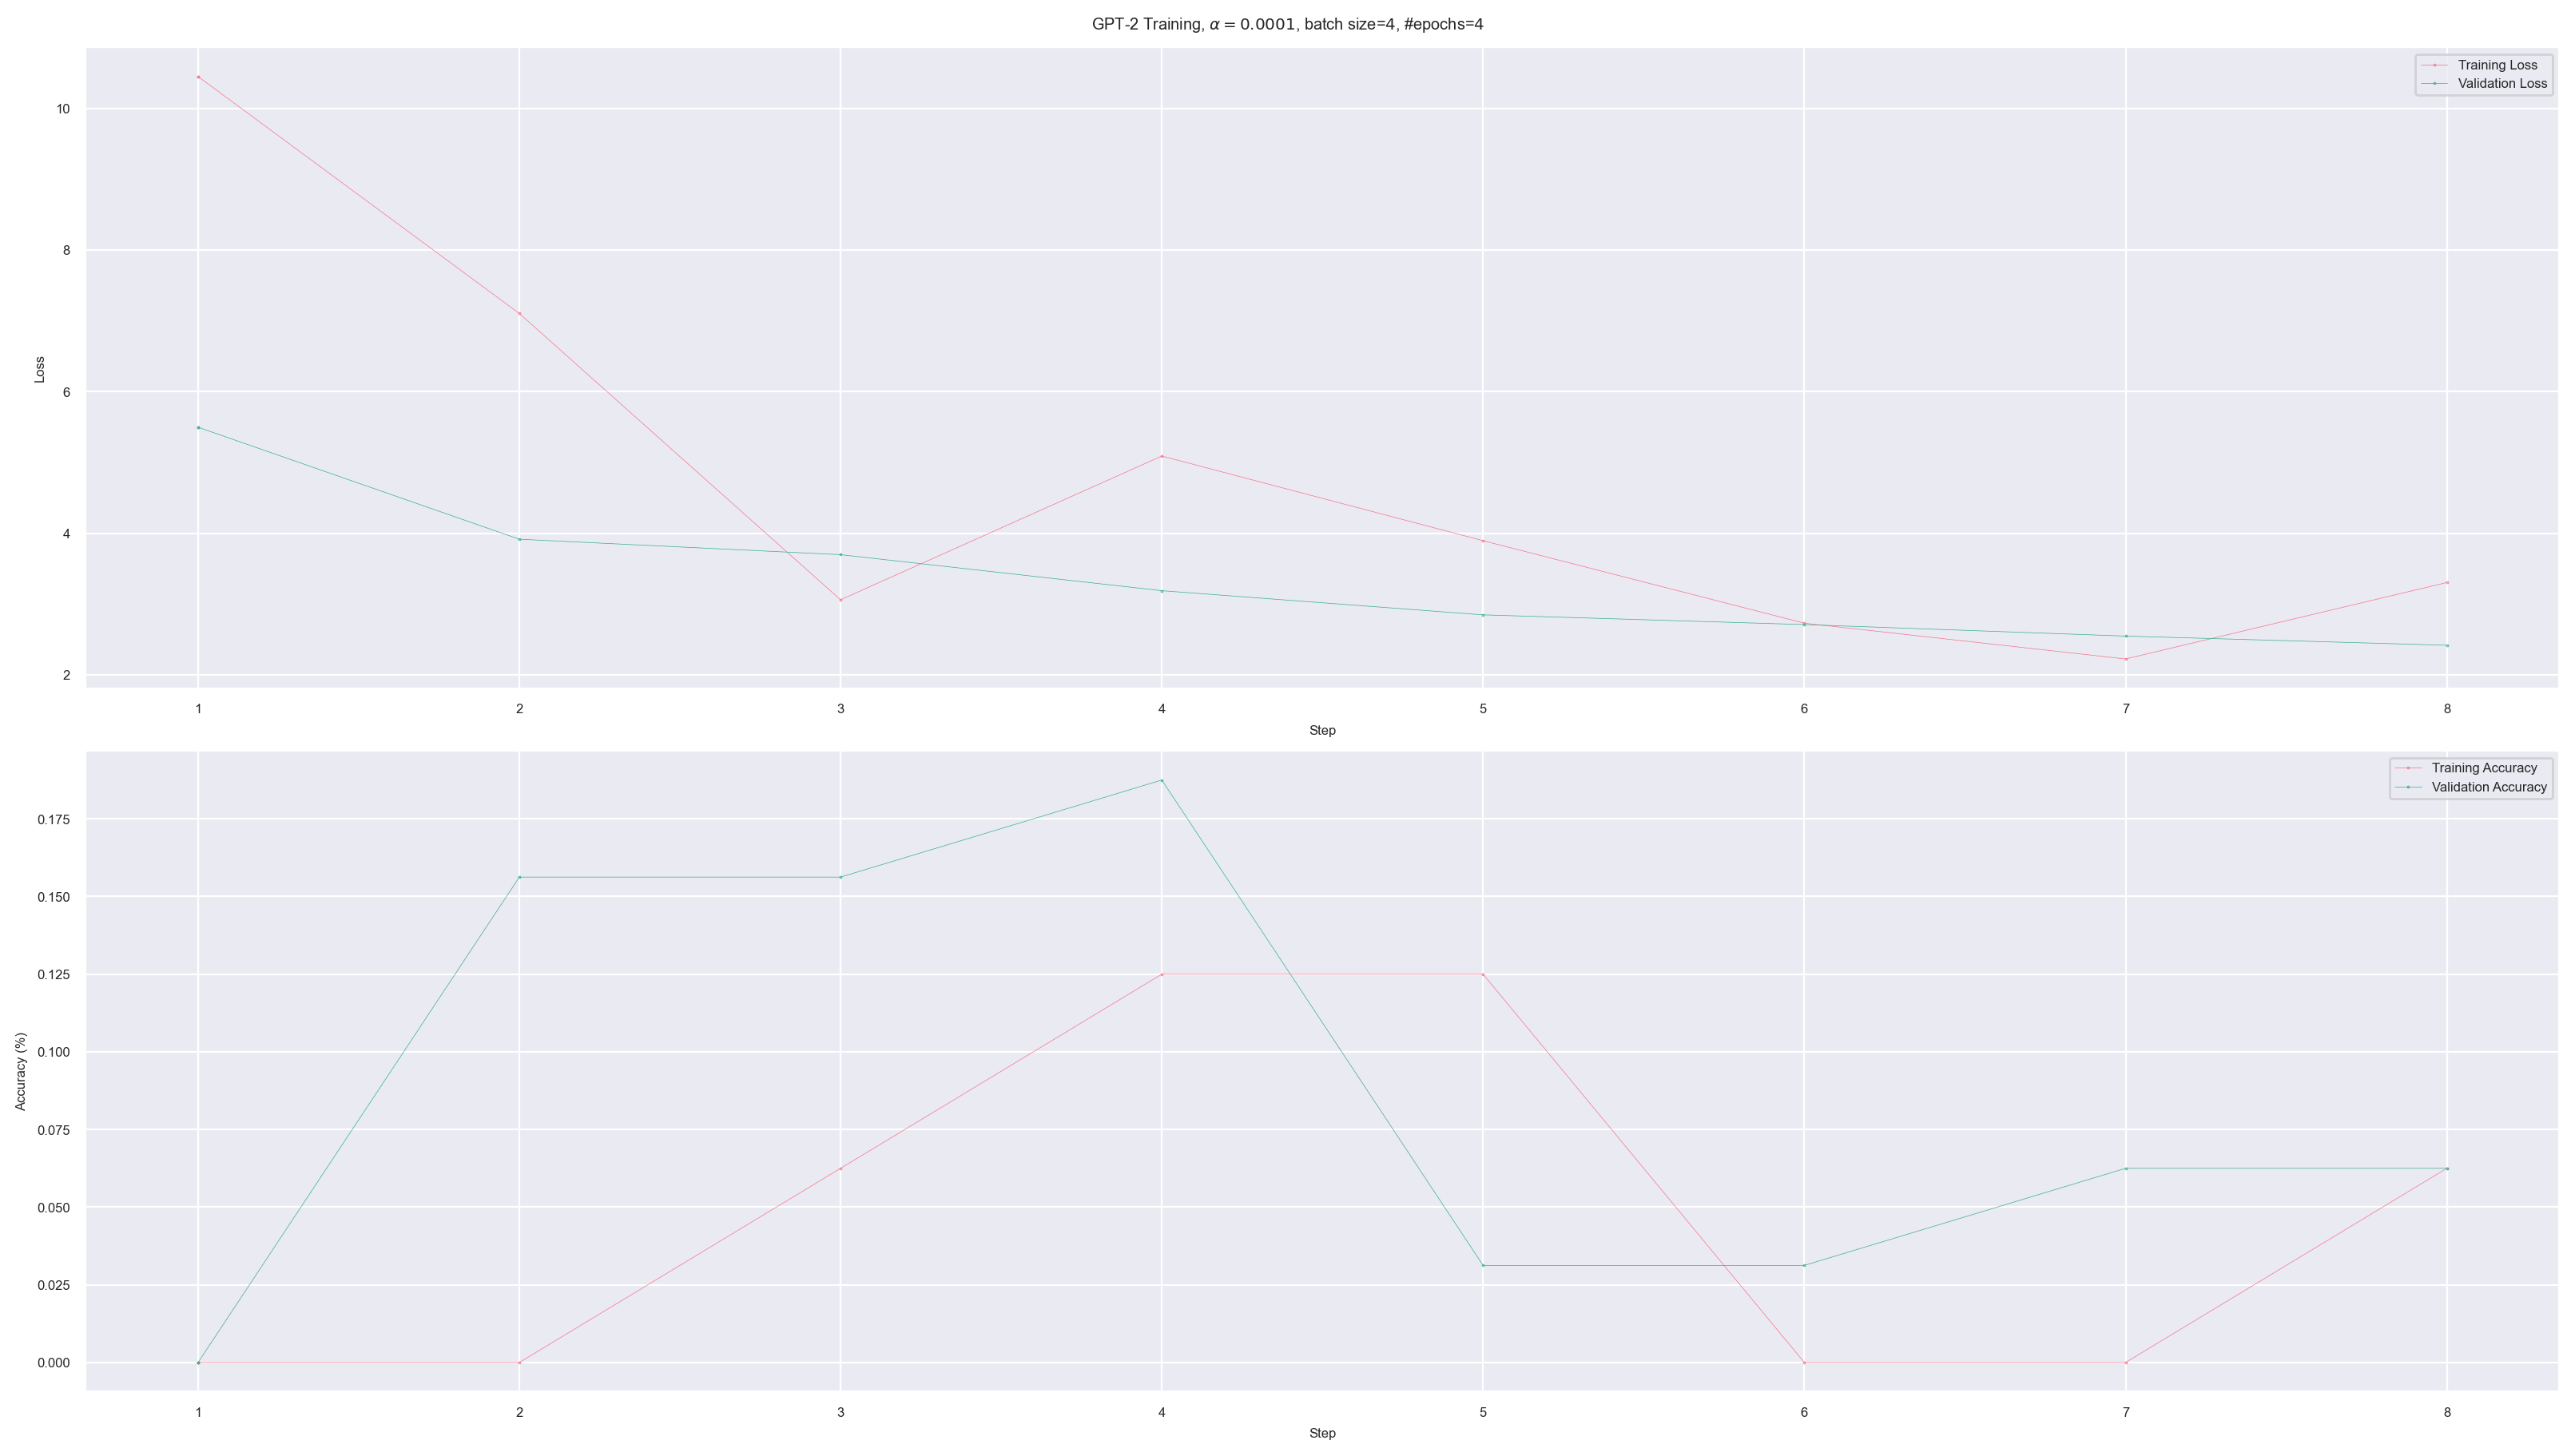

In [6]:
trainer.train()
trainer.save_model(os.path.join(trainer.args.output_dir, now(sep='-')))



## Evaluate


In [7]:
trainer.evaluate()



2022-02-16 14:10:18| [GPT-2 Training]::on_log::gpt2.py:634, INFO - {eval_loss: 2.4178881645202637, eval_accuracy: 0.0625, eval_runtime: 0.269, eval_samples_per_second: 29.739, eval_steps_per_second: 7.435, epoch: 4.0}


{'eval_loss': 2.4178881645202637,
 'eval_accuracy': 0.0625,
 'eval_runtime': 0.269,
 'eval_samples_per_second': 29.739,
 'eval_steps_per_second': 7.435,
 'epoch': 4.0}